In [119]:
import sys
sys.path.append('../src')

from pipelines import preprocessing_pipeline
from pipelines import classifier_pipeline

import os
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm 

import cv2
from skimage import io, color, transform, feature
from skimage.feature import hog, local_binary_pattern

from sklearn.base import (
    BaseEstimator, 
    TransformerMixin
)
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.metrics import (
    accuracy_score, 
    classification_report,
    confusion_matrix
)
from sklearn.svm import SVC

root_path = '../'
ck_data_path = os.path.join(root_path, 'data/CK+48')
jaffe_data_path = os.path.join(root_path, 'data/JAFFE')

# Data

In [120]:
ck_images, ck_labels = preprocessing_pipeline(ck_data_path, 'ck', verbose=True)
jaffe_images, jaffe_labels = preprocessing_pipeline(jaffe_data_path, 'jaffe', verbose=True)

100%|██████████| 981/981 [00:06<00:00, 141.00it/s]


Dataset: ck
Dataset length: 981
Image shape: (48, 48)


100%|██████████| 213/213 [00:00<00:00, 715.48it/s]

Dataset: jaffe
Dataset length: 213
Image shape: (256, 256)


# Handmade LBP

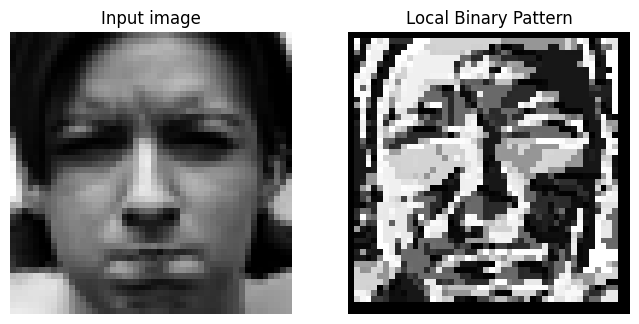

In [48]:
def handmade_lbp(image):                              

    h, w = image.shape
    result = np.zeros_like(image)
    
    kernel_size = 3

    for i in range(h-kernel_size):                 
        for j in range(w-kernel_size):           

            x = image[
                i:i+kernel_size,
                j:j+kernel_size
            ]                   
            center = x[1,1] # center value for 3*3 kernel

            # if neighbouring values of center value is greater than center value -> 1, else 0
            binary_image = (x >= center)*1.0 
            binary_image_vector = binary_image.T.flatten()  
            binary_image_vector = np.delete(binary_image_vector, 4) # remove the center
            digit = np.where(binary_image_vector)[0]         

            if len(digit) >= 1:                     # converting the neighbouring pixels according to center pixel value
                num = np.sum(2**digit)              # if n> center assign 1 and if n<center assign 0
            else:                                    # if 1 then multiply by 2^digit and if 0 then making value 0 and aggregating all the values of kernel to get new center value
                num = 0
            result[i+1,j+1] = num
    return (result)

image = ck_images[0]
lbp_image = handmade_lbp(image)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(image, cmap='gray')
ax1.set_title('Input image')
ax2.axis('off')
ax2.imshow(lbp_image, cmap='gray')
ax2.set_title('Local Binary Pattern')
plt.show()

# ```skimage``` LBP

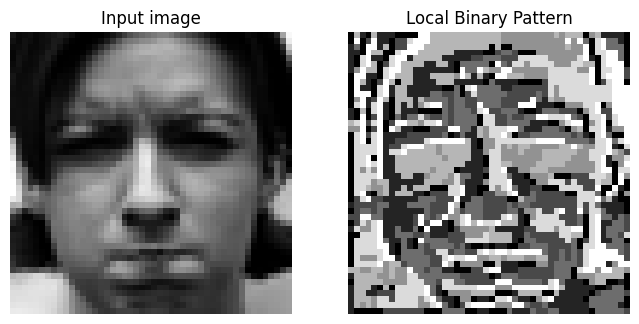

In [49]:
image = ck_images[0]
label = ck_labels[0]

lbp_image = feature.local_binary_pattern(
    image,
    P=3,
    R=1
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(image, cmap='gray')
ax1.set_title('Input image')
ax2.axis('off')
ax2.imshow(lbp_image, cmap='gray')
ax2.set_title('Local Binary Pattern')
plt.show()

# LBP Pipeline

In [106]:
def lbp_pipeline(
    images, 
    P = 3,
    R = 1,
    resize = None,
    verbose=False
):

    features = []

    for image in tqdm(images):

        if resize is not None:
            image = transform.resize(image, resize)

        lbp_image = feature.local_binary_pattern(
            image,
            P=P,
            R=R
        )
        image_features = lbp_image.flatten()
        features.append(image_features)

    features = np.array(features)
    
    if verbose:
        print(f"P: {P}")
        print(f"R: {R}")
        print(f"Features: {features.shape}")

    return features

In [123]:
lbp_features = lbp_pipeline(ck_images, resize=(32, 32))
lbp_features.shape

X = lbp_features
y = ck_labels 

train_results, test_results = classifier_pipeline(X, y, verbose=True)

  0%|          | 0/981 [00:00<?, ?it/s]c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
100%|██████████| 981/981 [00:00<00:00, 1360.03it/s]


Train Result:
Accuracy Score: 100.00%
Test Result:
Accuracy Score: 99.32%


In [124]:
lbp_features = lbp_pipeline(jaffe_images, resize=(32, 32))
print(lbp_features.shape)

X = lbp_features
y = jaffe_labels 

train_results, test_results = classifier_pipeline(X, y, verbose=True)

  0%|          | 0/213 [00:00<?, ?it/s]c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
100%|██████████| 213/213 [00:01<00:00, 196.99it/s]

(213, 1024)
Train Result:
Accuracy Score: 100.00%
Test Result:
Accuracy Score: 73.44%


### Gridsearch

In [111]:
class LBPTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, P=3, R=1, resize=None):
        self.P = P
        self.R = R
        self.resize = resize

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        features = lbp_pipeline(X, P=self.P, R=self.R, resize=self.resize)
        return np.array(features)


lbp_sk_pipeline = Pipeline([
    ('lbp_features', LBPTransformer(P=3, R=1, resize=(32,32))),
    ('svc', SVC(kernel='rbf', gamma='scale', C= 10))
])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    *preprocessing_pipeline(jaffe_data_path, 'jaffe'),
    test_size=0.25, random_state=42, shuffle=True
)

param_grid = {
    'lbp_features__P': [8, 16],
    'lbp_features__R': [1, 2, 3]
}

grid_search = GridSearchCV(
    estimator=lbp_sk_pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=4,
    verbose=3
)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
print("Best parameters found by grid search:")
print(best_params)


y_train_pred = best_estimator.predict(X_train)
print("\nTest Result:\n================================================")
print(f"Accuracy Score: {accuracy_score(y_train, y_train_pred) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{classification_report(y_train, y_train_pred)}")
print("_______________________________________________")
print(f"Confusion Matrix: \n{confusion_matrix(y_train, y_train_pred)}")


y_test_pred = best_estimator.predict(X_test)
print("\nTest Result:\n================================================")
print(f"Accuracy Score: {accuracy_score(y_test, y_test_pred) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{classification_report(y_test, y_test_pred)}")
print("_______________________________________________")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_test_pred)}")


# Best parameters found by grid search:
# {'lbp_features__P': 16, 'lbp_features__R': 3}
#   0%|          | 0/159 [00:00<?, ?it/s]c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
#   warnings.warn(
# 100%|██████████| 159/159 [00:01<00:00, 126.63it/s]

# Test Result:
# ================================================
# Accuracy Score: 100.00%
# _______________________________________________
# CLASSIFICATION REPORT:
#               precision    recall  f1-score   support

#        Anger       1.00      1.00      1.00        21
#      Disgust       1.00      1.00      1.00        25
#         Fear       1.00      1.00      1.00        22
#    Happiness       1.00      1.00      1.00        23
#      Neutral       1.00      1.00      1.00        21
#      Sadness       1.00      1.00      1.00        26
#     Surprise       1.00      1.00      1.00        21

#     accuracy                           1.00       159
#    macro avg       1.00      1.00      1.00       159
# weighted avg       1.00      1.00      1.00       159

# _______________________________________________
# Confusion Matrix: 
# [[21  0  0  0  0  0  0]
#  [ 0 25  0  0  0  0  0]
#  [ 0  0 22  0  0  0  0]
#  [ 0  0  0 23  0  0  0]
#  [ 0  0  0  0 21  0  0]
#  [ 0  0  0  0  0 26  0]
#  [ 0  0  0  0  0  0 21]]
#   0%|          | 0/54 [00:00<?, ?it/s]c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
#   warnings.warn(
# 100%|██████████| 54/54 [00:00<00:00, 141.60it/s]

# Test Result:
# ================================================
# Accuracy Score: 85.19%
# _______________________________________________
# CLASSIFICATION REPORT:
#               precision    recall  f1-score   support

#        Anger       0.86      0.67      0.75         9
#      Disgust       0.60      0.75      0.67         4
#         Fear       0.89      0.80      0.84        10
#    Happiness       1.00      1.00      1.00         8
#      Neutral       0.90      1.00      0.95         9
#      Sadness       0.71      1.00      0.83         5
#     Surprise       0.88      0.78      0.82         9

#     accuracy                           0.85        54
#    macro avg       0.83      0.86      0.84        54
# weighted avg       0.86      0.85      0.85        54

# _______________________________________________
# Confusion Matrix: 
# [[6 2 1 0 0 0 0]
#  [1 3 0 0 0 0 0]
#  [0 0 8 0 0 1 1]
#  [0 0 0 8 0 0 0]
#  [0 0 0 0 9 0 0]
#  [0 0 0 0 0 5 0]
#  [0 0 0 0 1 1 7]]

### full pipeline with optimal parameters

In [117]:
def full_lbp_pipeline(
    data_path, 
    dataset,
    P = 8,
    R = 3,
    resize = (32,32),
    test_size = 0.3,
    random_state = 42,
    verbose=False
):
    
    print('--- PREPROCESSING ---')
    images, labels = preprocessing_pipeline(
        data_path=data_path,
        dataset=dataset, 
        verbose=verbose
    ) 

    print('--- LBP ---')
    features = lbp_pipeline(
        images=images, 
        P=P, 
        R=R, 
        resize=resize,
        verbose=verbose
    )
    
    print('--- CLASSIF ---')
    train_results, test_results = classifier_pipeline(
        features=features,
        labels=labels,
        verbose=verbose
    )

    return train_results, test_results


In [121]:
train_results, test_results = full_lbp_pipeline(
    ck_data_path, 
    'ck',
    P = 8,
    R = 3,
    resize = (32,32),
    test_size = 0.3,
    random_state = 42,
    verbose=True
)

--- PREPROCESSING ---


100%|██████████| 981/981 [00:07<00:00, 130.73it/s]


Dataset: ck
Dataset length: 981
Image shape: (48, 48)
--- LBP ---


  0%|          | 0/981 [00:00<?, ?it/s]c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
100%|██████████| 981/981 [00:01<00:00, 767.43it/s] 


P: 8
R: 3
Features: (981, 1024)
--- CLASSIF ---
Train Result:
Accuracy Score: 100.00%
Test Result:
Accuracy Score: 100.00%


In [122]:
train_results, test_results = full_lbp_pipeline(
    jaffe_data_path, 
    'jaffe',
    P = 16,
    R = 3,
    resize = (32,32),
    test_size = 0.3,
    random_state = 42,
    verbose=True
)

--- PREPROCESSING ---


100%|██████████| 213/213 [00:00<00:00, 423.79it/s]


Dataset: jaffe
Dataset length: 213
Image shape: (256, 256)
--- LBP ---


  0%|          | 0/213 [00:00<?, ?it/s]c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
100%|██████████| 213/213 [00:01<00:00, 125.90it/s]


P: 16
R: 3
Features: (213, 1024)
--- CLASSIF ---
Train Result:
Accuracy Score: 100.00%
Test Result:
Accuracy Score: 85.94%
